In [87]:
import bz2
import json
import os
import random

# Directory containing all tracking files
data_dir = r"C:\Users\rusha\tactical_viewer\Tracking Data"

# Find all compressed tracking files
all_files = [
    f for f in os.listdir(data_dir)
    if f.endswith(".jsonl.bz2")
]

print(f"Found {len(all_files)} tracking files")

# Reproducible random sample (optional but recommended)
random.seed(42)
sample_files = random.sample(all_files, 5)

sample_files

all_rows = []

for file in sample_files:
    path = f"C:/Users/rusha/tactical_viewer/Tracking Data/{file}"

    with bz2.open(path, "rt", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if i >= 2000:
                break
            frame = json.loads(line)
            # reuse your existing flattening logic
            # append to all_rows


Found 61 tracking files


In [88]:
import pandas as pd

rows = []

for frame in frames:
    frame_num = frame.get("frameNum")
    period = frame.get("period")

    # Safely extract events (can be None)
    possession_event = frame.get("possession_event")
    possession_event_type = (
        possession_event.get("possession_event_type")
        if isinstance(possession_event, dict)
        else None
    )

    game_event = frame.get("game_event")
    game_event_type = (
        game_event.get("game_event_type")
        if isinstance(game_event, dict)
        else None
    )

    for p in frame.get("homePlayers", []):
        rows.append({
            "frame": frame_num,
            "period": period,
            "team": "home",
            "jersey": p.get("jerseyNum"),
            "visibility": p.get("visibility"),
            "x": p.get("x"),
            "y": p.get("y"),
            "possession_event_type": possession_event_type,
            "game_event_type": game_event_type,
        })

    for p in frame.get("awayPlayers", []):
        rows.append({
            "frame": frame_num,
            "period": period,
            "team": "away",
            "jersey": p.get("jerseyNum"),
            "visibility": p.get("visibility"),
            "x": p.get("x"),
            "y": p.get("y"),
            "possession_event_type": possession_event_type,
            "game_event_type": game_event_type,
        })

df = pd.DataFrame(rows)
df.head()

,frame,period,team,jersey,visibility,x,y,possession_event_type,game_event_type
0,4226,1,home,21,VISIBLE,13.975,19.244,PA,FIRSTKICKOFF
1,4226,1,home,4,VISIBLE,8.035,6.507,PA,FIRSTKICKOFF
2,4226,1,home,16,ESTIMATED,41.257,-0.454,PA,FIRSTKICKOFF
3,4226,1,home,6,VISIBLE,9.283,-0.842,PA,FIRSTKICKOFF
4,4226,1,home,22,VISIBLE,17.438,-22.039,PA,FIRSTKICKOFF


In [89]:
import matplotlib.pyplot as plt

shots = df[df["possession_event_type"] == "SH"]

len(shots)

176

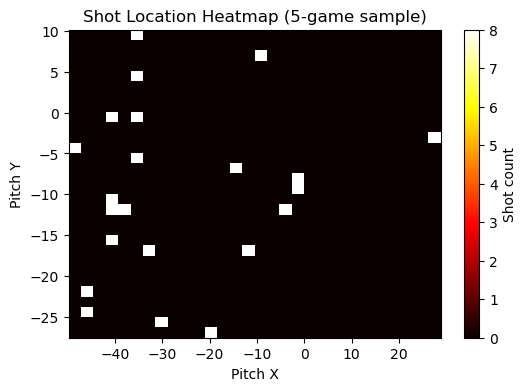

In [90]:
plt.figure(figsize=(6, 4))
plt.hist2d(
    shots["x"],
    shots["y"],
    bins=30,
    cmap="hot"
)
plt.colorbar(label="Shot count")
plt.title("Shot Location Heatmap (5-game sample)")
plt.xlabel("Pitch X")
plt.ylabel("Pitch Y")
plt.show()

In [91]:
buildup = df[df["possession_event_type"].isin(["PA", "BC"])]

len(buildup)

330

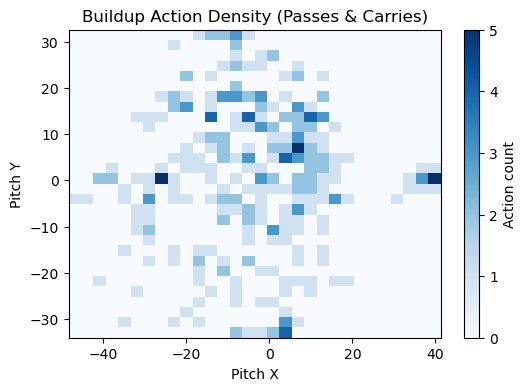

In [92]:
plt.figure(figsize=(6, 4))
plt.hist2d(
    buildup["x"],
    buildup["y"],
    bins=30,
    cmap="Blues"
)
plt.colorbar(label="Action count")
plt.title("Buildup Action Density (Passes & Carries)")
plt.xlabel("Pitch X")
plt.ylabel("Pitch Y")
plt.show()

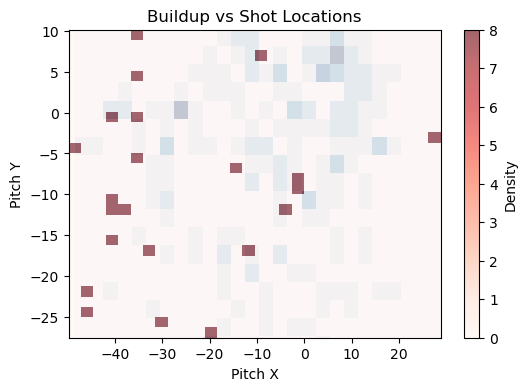

In [93]:
plt.figure(figsize=(6, 4))

plt.hist2d(
    buildup["x"], buildup["y"],
    bins=30, alpha=0.6, cmap="Blues"
)

plt.hist2d(
    shots["x"], shots["y"],
    bins=30, alpha=0.6, cmap="Reds"
)

plt.title("Buildup vs Shot Locations")
plt.xlabel("Pitch X")
plt.ylabel("Pitch Y")
plt.colorbar(label="Density")
plt.show()

In [94]:
shots[["x", "y"]].describe()

,x,y
count,176.000000,176.000000
mean,-26.129000,-9.574500
std,19.483083,10.087319
min,-49.745000,-27.585000
25%,-41.082000,-17.088000
50%,-34.922500,-9.844000
75%,-11.103000,-3.482000
max,28.773000,10.173000


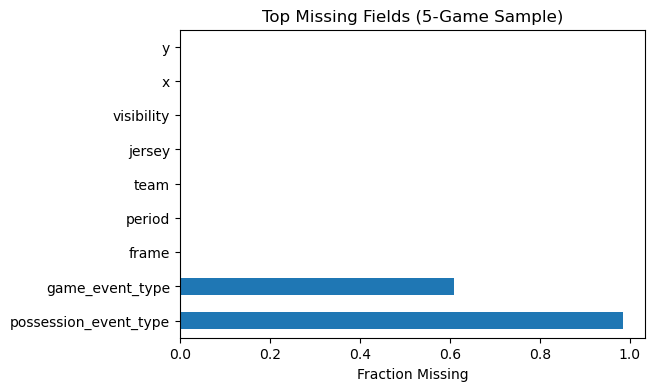

In [95]:
missing_pct = df.isna().mean().sort_values(ascending=False)

missing_pct.head(15).plot(
    kind="barh",
    figsize=(6, 4),
    title="Top Missing Fields (5-Game Sample)"
)
plt.xlabel("Fraction Missing")
plt.show()

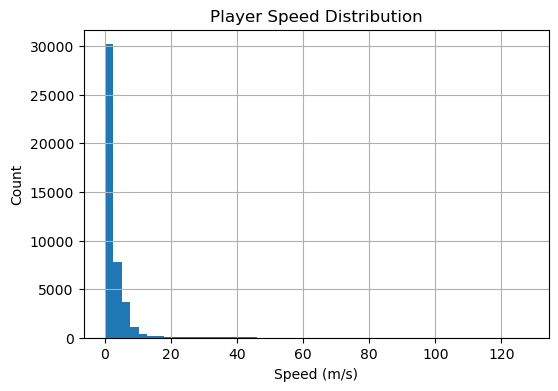

In [96]:
import numpy as np

df = df.sort_values(["team", "jersey", "frame"])

df["dx"] = df.groupby(["team", "jersey"])["x"].diff()
df["dy"] = df.groupby(["team", "jersey"])["y"].diff()
df["distance"] = np.sqrt(df["dx"]**2 + df["dy"]**2)

FPS = 25
df["speed_mps"] = df["distance"] * FPS

df["speed_mps"].dropna().hist(bins=50, figsize=(6,4))
plt.title("Player Speed Distribution")
plt.xlabel("Speed (m/s)")
plt.ylabel("Count")
plt.show()

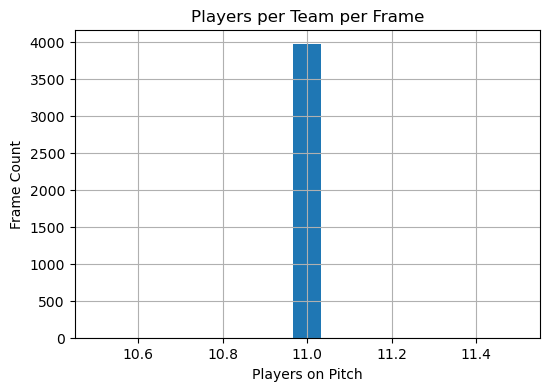

In [97]:
players_per_frame = (
    df.groupby(["frame", "team"])["jersey"]
      .nunique()
      .reset_index(name="n_players")
)

players_per_frame["n_players"].hist(bins=15, figsize=(6,4))
plt.title("Players per Team per Frame")
plt.xlabel("Players on Pitch")
plt.ylabel("Frame Count")
plt.show()

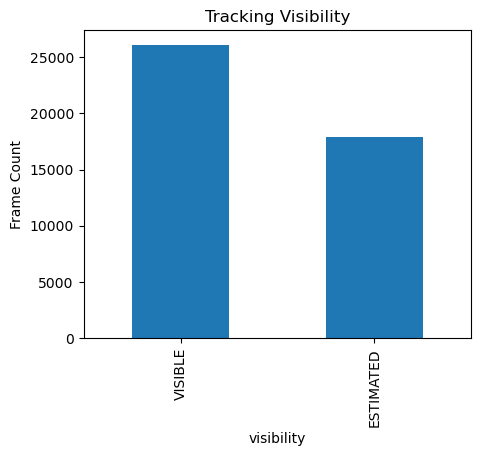

In [98]:
df["visibility"].value_counts().plot(
    kind="bar",
    figsize=(5,4),
    title="Tracking Visibility"
)
plt.ylabel("Frame Count")
plt.show()

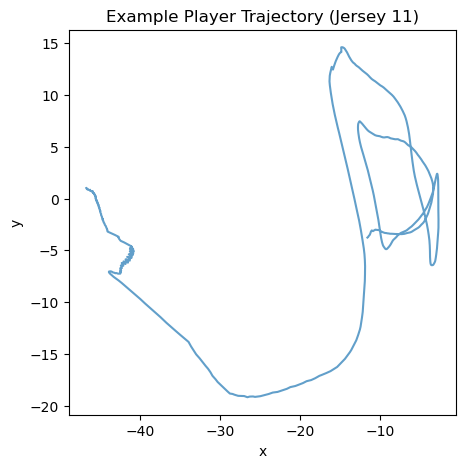

In [99]:
example = df.iloc[0]["jersey"]

traj = df[df["jersey"] == example]

plt.figure(figsize=(5,5))
plt.plot(traj["x"], traj["y"], alpha=0.7)
plt.title(f"Example Player Trajectory (Jersey {example})")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Data Size & Performance Notes
- Tracking data is recorded at 25 FPS and includes player- and ball-level coordinates per frame.
- This results in millions of player-rows per match when flattened to a player-frame table.
- File size grows primarily due to:
  - frame-level duplication (one row per player per frame)
  - storing both raw and smoothed coordinates
  - sparse event fields repeated across many frames
- Condensed representations (event-only data, downsampled tracking, or possession-level summaries)
  reduce data size by orders of magnitude.
- For EDA, analysis is performed on truncated frame samples and a small set of matches to
  keep iteration fast and memory usage reasonable.

In [100]:
df.memory_usage(deep=True).sum() / 1e6

np.float64(12.834078)

In [101]:
df["possession_event_type"].notna().mean()

np.float64(0.016)